In [1]:
import numpy as np
import pandas as pd
import datetime as dt

pd.set_option('display.max_rows', 16)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 9.0)
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import gc

In [2]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)

- [Data](#data)
  - [Risk free rate](#risk-free-rate)
  - [Beta](#beta)
  - [BM](#bm)
  - [Trading data](#trading-data)
    - [Monthly trading data](#monthly-trading-data)
    - [Momentum and reversal](#momentum-and-reversal)
- [Merge](#merge)
- [Monthly Factors](#monthly-factors)
  - [市场收益率](#市场收益率)
- [Daily factors](#daily-factors)


# Data

In [3]:
START = '2008-01-01'
END = '2025-04-30'
# Security Id
stk_info = DataAPI.SecIDGet(assetClass="E",pandas="1")
cond1 = (stk_info['exchangeCD'] == 'XSHE') | (stk_info['exchangeCD'] == 'XSHG')
cond2 = (stk_info['listStatusCD'] == 'L') | (stk_info['listStatusCD'] == 'DE')
cond3 = stk_info['transCurrCD']=='CNY'
stk_info = stk_info[cond1 & cond2 & cond3].copy()
stk_id = stk_info['secID']

## ST

In [4]:
st_df = DataAPI.SecSTGet(beginDate=START,endDate=END,secID=stk_id,field=['secID','tradeDate','STflg'],pandas="1")

In [5]:
st_df['tradeDate'] = pd.to_datetime(st_df['tradeDate'],format="%Y-%m-%d")

## Risk free rate

In [6]:
shibor_df = DataAPI.MktIborGet(secID="Shibor1M.IRCN",beginDate=START,endDate=END,field=['secID','tradeDate','rate'],pandas="1")
shibor_df['rate'] = shibor_df['rate']*0.01/12
shibor_df['tradeDate'] = pd.to_datetime(shibor_df['tradeDate'])
shibor_df.drop('secID',axis=1,inplace=True)
shibor_df.rename(columns={'rate':'rf'},inplace=True)
shibor_df['ym'] = shibor_df['tradeDate'].dt.to_period('M')
shibor_df.sort_values('tradeDate',inplace=True)
shibor_df_m = shibor_df.groupby('ym',as_index=False).last()
shibor_df_m.drop('tradeDate',axis=1,inplace=True)
shibor_df_m

ym        rf
0    2008-01  0.002949
1    2008-02  0.002946
2    2008-03  0.002746
3    2008-04  0.002862
4    2008-05  0.002953
5    2008-06  0.003113
6    2008-07  0.002806
7    2008-08  0.002681
..       ...       ...
200  2024-09  0.001517
201  2024-10  0.001517
202  2024-11  0.001477
203  2024-12  0.001401
204  2025-01  0.001422
205  2025-02  0.001557
206  2025-03  0.001607
207  2025-04  0.001516

[208 rows x 2 columns]

## Beta

In [7]:
beta_df = pd.read_pickle('./data/beta_df.pkl')
beta_df['tradeDate'] = pd.to_datetime(beta_df['tradeDate'], format="%Y-%m-%d")
beta_df['ym'] = beta_df['tradeDate'].dt.to_period('M')
# beta_df.drop(['Beta60','Beta120'],axis=1,inplace=True)
beta_df['Beta252'] = pd.to_numeric(beta_df['Beta252'])
# Winsorization
# up_q = 0.99999
# lower_q = 0.00001
# beta_df['Beta252_winsor'] = beta_df['Beta252'].clip(lower=beta_df['Beta252'].quantile(lower_q),upper=beta_df['Beta252'].quantile(up_q))
# Monthly
beta_df_m = beta_df.groupby(['secID','ym'],as_index=False)['Beta252'].last()
beta_df_m.rename(columns={'Beta252':'beta'},inplace=True)
beta_df_m

secID       ym    beta
0       000001.XSHE  2008-01  0.9654
1       000001.XSHE  2008-02  1.0292
2       000001.XSHE  2008-03  1.0238
3       000001.XSHE  2008-04  1.0212
4       000001.XSHE  2008-05  1.0697
5       000001.XSHE  2008-06  1.0672
6       000001.XSHE  2008-07  1.0966
7       000001.XSHE  2008-08  1.0386
...             ...      ...     ...
668784  689009.XSHG  2024-09  1.0361
668785  689009.XSHG  2024-10  1.3022
668786  689009.XSHG  2024-11  1.2585
668787  689009.XSHG  2024-12  1.2255
668788  689009.XSHG  2025-01  1.1695
668789  689009.XSHG  2025-02  1.2526
668790  689009.XSHG  2025-03  1.3115
668791  689009.XSHG  2025-04  1.3146

[668792 rows x 3 columns]

## BM

In [8]:
pb_df = pd.read_pickle('./data/pb_df.pkl')
pb_df['tradeDate'] = pd.to_datetime(pb_df['tradeDate'])
pb_df['PB'] = pd.to_numeric(pb_df['PB'])
pb_df['ym'] = pb_df['tradeDate'].dt.to_period('M')
pb_df.sort_values(['secID','tradeDate'],inplace=True)
pb_df = pb_df.groupby(['secID','ym'],as_index=False).last()
pb_df['bm'] = 1 / pb_df['PB']
pb_df.drop(['tradeDate','PB'],axis=1,inplace=True)
pb_df = pb_df[pb_df['bm'] >= 0]
pb_df

secID       ym        bm
0       000001.XSHE  2008-01  0.109513
1       000001.XSHE  2008-02  0.110009
2       000001.XSHE  2008-03  0.201102
3       000001.XSHE  2008-04  0.206701
4       000001.XSHE  2008-05  0.242665
5       000001.XSHE  2008-06  0.304090
6       000001.XSHE  2008-07  0.282598
7       000001.XSHE  2008-08  0.351136
...             ...      ...       ...
668784  689009.XSHG  2024-09  0.162713
668785  689009.XSHG  2024-10  0.190752
668786  689009.XSHG  2024-11  0.189876
668787  689009.XSHG  2024-12  0.177806
668788  689009.XSHG  2025-01  0.164468
668789  689009.XSHG  2025-02  0.147748
668790  689009.XSHG  2025-03  0.129505
668791  689009.XSHG  2025-04  0.134027

[661375 rows x 3 columns]

## Trading data

In [9]:
# %%time
# # About 8 mins
# # # 从优矿下载股票信息，时间较长。由于优矿的限制，每次下载3年的数据

# stk_dict = {}
# begin_ = dt.datetime.strptime(START, '%Y-%m-%d').year
# end_ = dt.datetime.strptime(START, '%Y-%m-%d').year+3
# field = ['secID','tradeDate','preClosePrice','closePrice','negMarketValue','turnoverValue','turnoverRate']
# while begin_ <= 2024:
#     if begin_ == 2024:
#         yesterday = dt.datetime.today() - dt.timedelta(days=1)
#         yesterday.strftime('%Y%m%d')
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=field,pandas="1")
#     else:
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                          beginDate=f'{begin_}0101',
#                                                          endDate=f'{end_}1231',
#                                                          field=field,pandas="1")
#     begin_ = end_ + 1
#     end_ = begin_ + 3
    
# for i in range(len(stk_dict)):
#     stk_df = pd.DataFrame(np.vstack([_df for _df in stk_dict.values()]),columns=field)
    
# stk_df.to_pickle('./data/stk_df.pkl')

In [10]:
# stk_df = pd.read_pickle('./data/stk_df.pkl')
# stk_df['tradeDate'] = pd.to_datetime(stk_df['tradeDate'], format='%Y-%m-%d')
# stk_df.sort_values(['secID','tradeDate'],inplace=True)
# # drop ST stocks
# print(stk_df.shape)
# stk_df = pd.merge(stk_df, st_df, on=['secID','tradeDate'],how='left')
# stk_df = stk_df[stk_df['STflg'].isna()].copy()
# stk_df.drop('STflg',axis=1,inplace=True)
# print(stk_df.shape)

In [11]:
# num_cols = ['preClosePrice','closePrice','negMarketValue','turnoverValue','turnoverRate']
# for col in num_cols:
#     stk_df[col] = pd.to_numeric(stk_df[col])

In [12]:
# # # If the trading days are required to be consecutive, fill missing days first. This could possibly produce a much larger df when using 
# ## daily data, and if the missing dates are a lot for some securities

# def fill_missing(df, full_dates, id_col='secID', date_col='tradeDate'):
#     """
#     This function fills the missing dates for stocks.
#     Parameters:
#         df: The dataframe. Could be a sub-dataframe created by "groupby".
#             The dataframe must be sorted on the "date_col".
#         full_dates: the unique dates covering all securities in the full dataframe. 
#                     Need to be sorted.
#         id_col: the security id.
#         date_col: the dates column for the security
#     Returns:
#         A dataframe with the missing dates filled with NA.
#     """
#     stk_id = df[id_col].unique()
#     # Newer version of pandas will allow comparison between "Timestamp" and "datetime64"
# #     date_start = np.where(full_dates == df[date_col].min())[0][0] 
# #     date_end = np.where(full_dates == df[date_col].max())[0][0]
#     date_start = np.where(full_dates == df[date_col].min().to_datetime64())[0][0] 
#     date_end = np.where(full_dates == df[date_col].max().to_datetime64())[0][0]
#     dates = full_dates[date_start:date_end+1]
#     idx = pd.MultiIndex.from_product([stk_id,dates],
#                                      names=(id_col,date_col))
#     df = df.set_index([id_col,date_col]).reindex(idx).reset_index()
#     return df

In [13]:
# full_dates = np.sort(stk_df['tradeDate'].unique())

In [14]:
# %%time
# stk_df = stk_df.groupby('secID').apply(fill_missing, full_dates=full_dates)

In [15]:
# stk_df.reset_index(drop=True, inplace=True)

# stk_df['ret_daily'] = stk_df['closePrice'] / stk_df['preClosePrice'] - 1
# stk_df['illiq_daily'] = abs(stk_df['ret_daily'].values) / stk_df['turnoverValue'].values
# stk_df.loc[np.isinf(stk_df['illiq_daily']),'illiq_daily'] = np.nan
# stk_df['ym'] = stk_df['tradeDate'].dt.to_period('M')

# stk_df.to_pickle('./data/stk_df_filled.pkl')

In [16]:
stk_df = pd.read_pickle('./data/stk_df_filled.pkl')

In [17]:
stk_df

secID  tradeDate  preClosePrice  closePrice  negMarketValue  \
0         000001.XSHE 2008-01-02       1221.497    1201.877    6.672404e+10   
1         000001.XSHE 2008-01-03       1201.877    1181.940    6.561725e+10   
2         000001.XSHE 2008-01-04       1181.940    1214.218    6.740920e+10   
3         000001.XSHE 2008-01-07       1214.218    1239.534    6.881466e+10   
4         000001.XSHE 2008-01-08       1239.534    1278.141    7.095798e+10   
5         000001.XSHE 2008-01-09       1278.141    1300.926    7.222289e+10   
6         000001.XSHE 2008-01-10       1300.926    1327.507    7.369862e+10   
7         000001.XSHE 2008-01-11       1327.507    1394.911    7.744065e+10   
...               ...        ...            ...         ...             ...   
13182725  689009.XSHG 2025-03-26         62.447      62.437    3.408568e+10   
13182726  689009.XSHG 2025-03-27         62.437      65.760    3.589992e+10   
13182727  689009.XSHG 2025-03-28         65.760      65.609    3.581745e+10   
13182728  689009.XSHG 2025-03-31         65.609      65.659    3.584494e+10   
13182729  689009.XSHG 2025-04-01         65.659      64.411    3.516323e+10   
13182730  689009.XSHG 2025-04-02         64.411      64.149    3.502029e+10   
13182731  689009.XSHG 2025-04-03         64.149      63.444    3.463545e+10   
13182732  689009.XSHG 2025-04-07         63.444      53.665    2.929719e+10   

          turnoverValue  turnoverRate  ret_daily   illiq_daily       ym  
0          7.634657e+08        0.0114  -0.016062  2.103861e-11  2008-01  
1          1.023423e+09        0.0157  -0.016588  1.620857e-11  2008-01  
2          7.621612e+08        0.0113   0.027309  3.583145e-11  2008-01  
3          1.236910e+09        0.0179   0.020850  1.685622e-11  2008-01  
4          2.029248e+09        0.0285   0.031146  1.534873e-11  2008-01  
5          7.863130e+08        0.0110   0.017827  2.267122e-11  2008-01  
6          1.016738e+09        0.0139   0.020432  2.009601e-11  2008-01  
7          1.555168e+09        0.0204   0.050775  3.264912e-11  2008-01  
...                 ...           ...        ...           ...      ...  
13182725   2.834881e+08        0.0083  -0.000160  5.648766e-13  2025-03  
13182726   6.975345e+08        0.0197   0.053222  7.629967e-11  2025-03  
13182727   3.724902e+08        0.0104  -0.002296  6.164534e-12  2025-03  
13182728   5.167717e+08        0.0144   0.000762  1.474714e-12  2025-03  
13182729   4.671283e+08        0.0133  -0.019007  4.068967e-11  2025-04  
13182730   2.618055e+08        0.0075  -0.004068  1.553683e-11  2025-04  
13182731   1.100406e+09        0.0334  -0.010990  9.987255e-12  2025-04  
13182732   1.006334e+09        0.0336  -0.154136  1.531658e-10  2025-04  

[13182733 rows x 10 columns]

### Monthly trading data

In [18]:
stk_df_m = stk_df.groupby(['secID','ym'],as_index=False).last()

#### 新股问题

In [19]:
list_date = stk_info[['secID','listDate']].copy()
list_date['listDate'] = pd.to_datetime(list_date['listDate'],format="%Y-%m-%d")
list_date['listMonth'] = list_date['listDate'].dt.to_period('M')
# list_date

stk_df_m = pd.merge(stk_df_m,list_date[['secID','listMonth']],on='secID')
# stk_df_m

stk_listMonth = stk_df_m.groupby('secID')[['ym','listMonth']].first()
stk_listMonth['listm_dist'] = stk_listMonth['ym'] - stk_listMonth['listMonth']
# pandas 版本太久
stk_listMonth['listm_dist'] = stk_listMonth['listm_dist'].apply(lambda x: x.n)

# 上市日期在样本内的新上市股票
stk_listMonth.loc[stk_listMonth['listm_dist'] < 1]

newlist_secID = stk_listMonth.loc[stk_listMonth['listm_dist'] < 1].index
newlist_secID

# 每只股票丢掉第一个观测值
temp = stk_df_m.loc[stk_df_m['secID'].isin(newlist_secID)].groupby('secID').apply(lambda x: x.iloc[1:]).drop('secID',axis=1).reset_index().drop('level_1',axis=1)

stk_df_m = pd.concat([stk_df_m.loc[~stk_df_m['secID'].isin(newlist_secID)],temp],axis=0).reset_index(drop=True)

# stk_df_m.drop('listMonth',axis=1,inplace=True)
stk_df_m = stk_df_m.sort_values(['secID', 'ym']).reset_index(drop=True)
stk_df_m

secID       ym  tradeDate  preClosePrice  closePrice  \
0       000001.XSHE  2008-01 2008-01-31       1074.347    1053.778   
1       000001.XSHE  2008-02 2008-02-29       1037.956    1049.032   
2       000001.XSHE  2008-03 2008-03-31        918.971     892.389   
3       000001.XSHE  2008-04 2008-04-30        884.478     937.325   
4       000001.XSHE  2008-05 2008-05-30        789.543     798.403   
5       000001.XSHE  2008-06 2008-06-30        615.179     611.698   
6       000001.XSHE  2008-07 2008-07-31        681.317     658.216   
7       000001.XSHE  2008-08 2008-08-29        635.115     639.229   
...             ...      ...        ...            ...         ...   
654067  689009.XSHG  2024-09 2024-09-30         43.333      48.540   
654068  689009.XSHG  2024-10 2024-10-31         44.904      44.612   
654069  689009.XSHG  2024-11 2024-11-29         43.434      44.813   
654070  689009.XSHG  2024-12 2024-12-31         48.469      47.835   
654071  689009.XSHG  2025-01 2025-01-27         53.514      51.702   
654072  689009.XSHG  2025-02 2025-02-28         58.409      57.553   
654073  689009.XSHG  2025-03 2025-03-31         65.609      65.659   
654074  689009.XSHG  2025-04 2025-04-07         63.444      53.665   

        negMarketValue  turnoverValue  turnoverRate  ret_daily   illiq_daily  \
0         5.850212e+10   5.328429e+08        0.0089  -0.019146  3.593101e-11   
1         5.823860e+10   2.267900e+08        0.0039   0.010671  4.705222e-11   
2         4.954234e+10   6.155862e+08        0.0123  -0.028926  4.698908e-11   
3         5.203702e+10   9.029705e+08        0.0176   0.059749  6.616979e-11   
4         4.432458e+10   2.049950e+08        0.0046   0.011222  5.474125e-11   
5         4.140495e+10   3.618398e+08        0.0088  -0.005659  1.563818e-11   
6         4.455369e+10   2.188600e+08        0.0048  -0.033906  1.549227e-10   
7         4.326849e+10   3.096257e+08        0.0071   0.006478  2.092064e-11   
...                ...            ...           ...        ...           ...   
654067    2.633272e+10   1.248639e+09        0.0490   0.120162  9.623476e-11   
654068    2.420206e+10   3.709377e+08        0.0153  -0.006503  1.753060e-11   
654069    2.431436e+10   4.117342e+08        0.0170   0.031749  7.711121e-11   
654070    2.610548e+10   3.727989e+08        0.0142  -0.013081  3.508735e-11   
654071    2.822514e+10   6.545678e+08        0.0236  -0.033860  5.172925e-11   
654072    3.141930e+10   5.978337e+08        0.0190  -0.014655  2.451397e-11   
654073    3.584494e+10   5.167717e+08        0.0144   0.000762  1.474714e-12   
654074    2.929719e+10   1.006334e+09        0.0336  -0.154136  1.531658e-10   

       listMonth  
0        1991-04  
1        1991-04  
2        1991-04  
3        1991-04  
4        1991-04  
5        1991-04  
6        1991-04  
7        1991-04  
...          ...  
654067   2020-10  
654068   2020-10  
654069   2020-10  
654070   2020-10  
654071   2020-10  
654072   2020-10  
654073   2020-10  
654074   2020-10  

[654075 rows x 11 columns]

In [20]:
stk_df_m['ret'] = stk_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1)
stk_df_m['size'] = np.log(stk_df_m['negMarketValue'])
stk_df_m.drop(['tradeDate','preClosePrice'],axis=1,inplace=True)
stk_df_m = pd.merge(stk_df_m, shibor_df_m, on='ym')
stk_df_m['exret'] = stk_df_m['ret'] - stk_df_m['rf']
stk_df_m.sort_values(['secID','ym'],inplace=True)
stk_df_m.rename(columns={'negMarketValue':'mktcap'},inplace=True)
stk_df_m

secID       ym  closePrice        mktcap  turnoverValue  \
0       000001.XSHE  2008-01    1053.778  5.850212e+10   5.328429e+08   
1339    000001.XSHE  2008-02    1049.032  5.823860e+10   2.267900e+08   
2690    000001.XSHE  2008-03     892.389  4.954234e+10   6.155862e+08   
4060    000001.XSHE  2008-04     937.325  5.203702e+10   9.029705e+08   
5440    000001.XSHE  2008-05     798.403  4.432458e+10   2.049950e+08   
6837    000001.XSHE  2008-06     611.698  4.140495e+10   3.618398e+08   
8265    000001.XSHE  2008-07     658.216  4.455369e+10   2.188600e+08   
9707    000001.XSHE  2008-08     639.229  4.326849e+10   3.096257e+08   
...             ...      ...         ...           ...            ...   
619119  689009.XSHG  2024-09      48.540  2.633272e+10   1.248639e+09   
624098  689009.XSHG  2024-10      44.612  2.420206e+10   3.709377e+08   
629084  689009.XSHG  2024-11      44.813  2.431436e+10   4.117342e+08   
634072  689009.XSHG  2024-12      47.835  2.610548e+10   3.727989e+08   
639066  689009.XSHG  2025-01      51.702  2.822514e+10   6.545678e+08   
644069  689009.XSHG  2025-02      57.553  3.141930e+10   5.978337e+08   
649071  689009.XSHG  2025-03      65.659  3.584494e+10   5.167717e+08   
654074  689009.XSHG  2025-04      53.665  2.929719e+10   1.006334e+09   

        turnoverRate  ret_daily   illiq_daily listMonth       ret       size  \
0             0.0089  -0.019146  3.593101e-11   1991-04       NaN  24.792329   
1339          0.0039   0.010671  4.705222e-11   1991-04 -0.004504  24.787814   
2690          0.0123  -0.028926  4.698908e-11   1991-04 -0.149321  24.626093   
4060          0.0176   0.059749  6.616979e-11   1991-04  0.050355  24.675221   
5440          0.0046   0.011222  5.474125e-11   1991-04 -0.148211  24.514805   
6837          0.0088  -0.005659  1.563818e-11   1991-04 -0.233848  24.446666   
8265          0.0048  -0.033906  1.549227e-10   1991-04  0.076047  24.519961   
9707          0.0071   0.006478  2.092064e-11   1991-04 -0.028846  24.490690   
...              ...        ...           ...       ...       ...        ...   
619119        0.0490   0.120162  9.623476e-11   2020-10  0.078307  23.994078   
624098        0.0153  -0.006503  1.753060e-11   2020-10 -0.080923  23.909704   
629084        0.0170   0.031749  7.711121e-11   2020-10  0.004506  23.914333   
634072        0.0142  -0.013081  3.508735e-11   2020-10  0.067436  23.985411   
639066        0.0236  -0.033860  5.172925e-11   2020-10  0.080840  24.063479   
644069        0.0190  -0.014655  2.451397e-11   2020-10  0.113168  24.170688   
649071        0.0144   0.000762  1.474714e-12   2020-10  0.140844  24.302468   
654074        0.0336  -0.154136  1.531658e-10   2020-10 -0.182671  24.100757   

              rf     exret  
0       0.002949       NaN  
1339    0.002946 -0.007450  
2690    0.002746 -0.152068  
4060    0.002862  0.047493  
5440    0.002953 -0.151164  
6837    0.003113 -0.236961  
8265    0.002806  0.073241  
9707    0.002681 -0.031527  
...          ...       ...  
619119  0.001517  0.076791  
624098  0.001517 -0.082440  
629084  0.001477  0.003029  
634072  0.001401  0.066035  
639066  0.001422  0.079419  
644069  0.001557  0.111611  
649071  0.001607  0.139237  
654074  0.001516 -0.184187  

[654075 rows x 13 columns]

In [21]:
stk_df_m[stk_df_m['secID'] == '000001.XSHE'].set_index('ym').loc['2010-01':'2010-12']
# 停牌的时间都填充为NaN。刚恢复交易的第一个月的月收益率也为NaN

secID  closePrice        mktcap  turnoverValue  turnoverRate  \
ym                                                                            
2010-01  000001.XSHE     895.357  6.345328e+10   5.284377e+08        0.0082   
2010-02  000001.XSHE     926.303  6.564637e+10   1.008966e+09        0.0154   
2010-03  000001.XSHE     957.248  6.783945e+10   7.105142e+08        0.0104   
2010-04  000001.XSHE     848.320  6.011979e+10   6.628292e+08        0.0111   
2010-05  000001.XSHE     722.475  5.120124e+10   4.806838e+08        0.0092   
2010-06  000001.XSHE     722.475  5.437499e+10   0.000000e+00        0.0000   
2010-07  000001.XSHE     722.475  5.437499e+10   0.000000e+00        0.0000   
2010-08  000001.XSHE     722.475  5.437499e+10   0.000000e+00        0.0000   
2010-09  000001.XSHE     669.249  5.036906e+10   0.000000e+00        0.0000   
2010-10  000001.XSHE     759.610  5.716982e+10   6.635094e+08        0.0115   
2010-11  000001.XSHE     676.263  5.089697e+10   4.642922e+08        0.0091   
2010-12  000001.XSHE     651.507  4.903361e+10   3.783178e+08        0.0078   

         ret_daily   illiq_daily listMonth       ret       size        rf  \
ym                                                                          
2010-01  -0.002299  4.350204e-12   1991-04 -0.109561  24.873570  0.001511   
2010-02   0.013544  1.342342e-11   1991-04  0.034563  24.907548  0.001547   
2010-03  -0.019028  2.678085e-11   1991-04  0.033407  24.940410  0.001450   
2010-04   0.019336  2.917199e-11   1991-04 -0.113793  24.819605  0.001464   
2010-05  -0.031527  6.558795e-11   1991-04 -0.148346  24.659030  0.002081   
2010-06   0.000000  9.651729e-11   1991-04  0.000000  24.719170  0.003236   
2010-07   0.000000           NaN   1991-04  0.000000  24.719170  0.001798   
2010-08   0.000000           NaN   1991-04  0.000000  24.719170  0.002369   
2010-09   0.000000  7.082247e-12   1991-04 -0.073672  24.642643  0.002922   
2010-10  -0.019178  2.890457e-11   1991-04  0.135019  24.769292  0.002214   
2010-11  -0.019737  4.250943e-11   1991-04 -0.109723  24.653069  0.003092   
2010-12   0.007659  2.024503e-11   1991-04 -0.036607  24.615772  0.005141   

            exret  
ym                 
2010-01 -0.111072  
2010-02  0.033016  
2010-03  0.031957  
2010-04 -0.115256  
2010-05 -0.150427  
2010-06 -0.003236  
2010-07 -0.001798  
2010-08 -0.002369  
2010-09 -0.076594  
2010-10  0.132805  
2010-11 -0.112815  
2010-12 -0.041748

### Momentum and reversal

#### Using unfilled data

In [22]:
stk_unfilled_df = pd.read_pickle('./data/stk_df.pkl')
stk_unfilled_df['tradeDate'] = pd.to_datetime(stk_unfilled_df['tradeDate'], format='%Y-%m-%d')
stk_unfilled_df['ym'] = stk_unfilled_df['tradeDate'].dt.to_period('M')
stk_unfilled_df.sort_values(['secID','tradeDate'],inplace=True)
# drop ST stocks
print(stk_unfilled_df.shape)
stk_unfilled_df = pd.merge(stk_unfilled_df, st_df, on=['secID','tradeDate'],how='left')
stk_unfilled_df = stk_unfilled_df[stk_unfilled_df['STflg'].isna()].copy()
stk_unfilled_df.drop('STflg',axis=1,inplace=True)
print(stk_unfilled_df.shape)
# Monthly
stk_unfilled_df_m = stk_unfilled_df.groupby(['secID','ym'],as_index=False).last()

(13411003, 8)
(12878387, 8)


#### 新股问题

In [23]:
stk_unfilled_df_m = pd.merge(stk_unfilled_df_m,list_date[['secID','listMonth']],on='secID')
# stk_unfilled_df_m
stk_listMonth = stk_unfilled_df_m.groupby('secID')[['ym','listMonth']].first()
stk_listMonth['listm_dist'] = stk_listMonth['ym'] - stk_listMonth['listMonth']
# pandas 版本太久
stk_listMonth['listm_dist'] = stk_listMonth['listm_dist'].apply(lambda x: x.n)

# 上市日期在样本内的新上市股票
stk_listMonth.loc[stk_listMonth['listm_dist'] < 1]

newlist_secID = stk_listMonth.loc[stk_listMonth['listm_dist'] < 1].index
newlist_secID

# 每只股票丢掉第一个观测值
temp = stk_unfilled_df_m.loc[stk_unfilled_df_m['secID'].isin(newlist_secID)].groupby('secID').apply(lambda x: x.iloc[1:]).drop('secID',axis=1).reset_index().drop('level_1',axis=1)

stk_unfilled_df_m = pd.concat([stk_unfilled_df_m.loc[~stk_unfilled_df_m['secID'].isin(newlist_secID)],temp],axis=0).reset_index(drop=True)

# stk_unfilled_df_m.drop('listMonth',axis=1,inplace=True)

stk_unfilled_df_m = stk_unfilled_df_m.sort_values(['secID', 'ym']).reset_index(drop=True)
stk_unfilled_df_m

secID       ym  tradeDate  preClosePrice  closePrice  \
0       000001.XSHE  2008-01 2008-01-31       1074.347    1053.778   
1       000001.XSHE  2008-02 2008-02-29       1037.956    1049.032   
2       000001.XSHE  2008-03 2008-03-31        918.971     892.389   
3       000001.XSHE  2008-04 2008-04-30        884.478     937.325   
4       000001.XSHE  2008-05 2008-05-30        789.543     798.403   
5       000001.XSHE  2008-06 2008-06-30        615.179     611.698   
6       000001.XSHE  2008-07 2008-07-31        681.317     658.216   
7       000001.XSHE  2008-08 2008-08-29        635.115     639.229   
...             ...      ...        ...            ...         ...   
639548  689009.XSHG  2024-09 2024-09-30         43.333      48.540   
639549  689009.XSHG  2024-10 2024-10-31         44.904      44.612   
639550  689009.XSHG  2024-11 2024-11-29         43.434      44.813   
639551  689009.XSHG  2024-12 2024-12-31         48.469      47.835   
639552  689009.XSHG  2025-01 2025-01-27         53.514      51.702   
639553  689009.XSHG  2025-02 2025-02-28         58.409      57.553   
639554  689009.XSHG  2025-03 2025-03-31         65.609      65.659   
639555  689009.XSHG  2025-04 2025-04-07         63.444      53.665   

        negMarketValue  turnoverValue  turnoverRate listMonth  
0         5.850212e+10   5.328429e+08        0.0089   1991-04  
1         5.823860e+10   2.267900e+08        0.0039   1991-04  
2         4.954234e+10   6.155862e+08        0.0123   1991-04  
3         5.203702e+10   9.029705e+08        0.0176   1991-04  
4         4.432458e+10   2.049950e+08        0.0046   1991-04  
5         4.140495e+10   3.618398e+08        0.0088   1991-04  
6         4.455369e+10   2.188600e+08        0.0048   1991-04  
7         4.326849e+10   3.096257e+08        0.0071   1991-04  
...                ...            ...           ...       ...  
639548    2.633272e+10   1.248639e+09        0.0490   2020-10  
639549    2.420206e+10   3.709377e+08        0.0153   2020-10  
639550    2.431436e+10   4.117342e+08        0.0170   2020-10  
639551    2.610548e+10   3.727989e+08        0.0142   2020-10  
639552    2.822514e+10   6.545678e+08        0.0236   2020-10  
639553    3.141930e+10   5.978337e+08        0.0190   2020-10  
639554    3.584494e+10   5.167717e+08        0.0144   2020-10  
639555    2.929719e+10   1.006334e+09        0.0336   2020-10  

[639556 rows x 9 columns]

In [24]:
stk_unfilled_df_m['ret_mom'] = stk_unfilled_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1) #这个ret_mom不用作后面ret的计算，后面仍保留monthly ret
stk_unfilled_df_m.sort_values(['secID','ym'],inplace=True)
stk_unfilled_df_m['1+ret_mom'] = stk_unfilled_df_m['ret_mom'] + 1

In [25]:
stk_unfilled_df_m['mom'] = stk_unfilled_df_m.groupby('secID').rolling(11,min_periods=9)['1+ret_mom'].apply(np.prod, raw=True).values - 1

In [26]:
stk_df_m = pd.merge(stk_df_m, stk_unfilled_df_m[['secID','ym','1+ret_mom']],on=['secID','ym'],how='left')
stk_df_m.loc[stk_df_m['1+ret_mom'].isna(),'1+ret_mom'] = 1 # 缺失位置填充为1，以便连乘。
stk_df_m['mom'] = stk_df_m.groupby('secID').rolling(11,min_periods=11)['1+ret_mom'].apply(np.prod, raw=True).values - 1 

In [27]:
stk_df_m['rev'] = stk_df_m['exret'].values
stk_df_m['ret'] = stk_df_m.groupby(['secID'])['ret'].shift(-1)
stk_df_m['rf'] = stk_df_m.groupby(['secID'])['rf'].shift(-1)
stk_df_m['exret'] = stk_df_m.groupby(['secID'])['exret'].shift(-1)
stk_df_m['ret_date'] = stk_df_m.groupby('secID')['ym'].shift(-1)

stk_df_m['mom'] = stk_df_m.groupby(['secID'])['mom'].shift()
stk_df_m['mom_date'] = stk_df_m.groupby('secID')['ym'].shift()

In [28]:
stk_df_m.drop(['ret_daily','turnoverValue','turnoverRate','illiq_daily','1+ret_mom'],axis=1,inplace=True)

In [29]:
stk_df_m

secID       ym  closePrice        mktcap listMonth       ret  \
0       000001.XSHE  2008-01    1053.778  5.850212e+10   1991-04 -0.004504   
1       000001.XSHE  2008-02    1049.032  5.823860e+10   1991-04 -0.149321   
2       000001.XSHE  2008-03     892.389  4.954234e+10   1991-04  0.050355   
3       000001.XSHE  2008-04     937.325  5.203702e+10   1991-04 -0.148211   
4       000001.XSHE  2008-05     798.403  4.432458e+10   1991-04 -0.233848   
5       000001.XSHE  2008-06     611.698  4.140495e+10   1991-04  0.076047   
6       000001.XSHE  2008-07     658.216  4.455369e+10   1991-04 -0.028846   
7       000001.XSHE  2008-08     639.229  4.326849e+10   1991-04 -0.257922   
...             ...      ...         ...           ...       ...       ...   
654067  689009.XSHG  2024-09      48.540  2.633272e+10   2020-10 -0.080923   
654068  689009.XSHG  2024-10      44.612  2.420206e+10   2020-10  0.004506   
654069  689009.XSHG  2024-11      44.813  2.431436e+10   2020-10  0.067436   
654070  689009.XSHG  2024-12      47.835  2.610548e+10   2020-10  0.080840   
654071  689009.XSHG  2025-01      51.702  2.822514e+10   2020-10  0.113168   
654072  689009.XSHG  2025-02      57.553  3.141930e+10   2020-10  0.140844   
654073  689009.XSHG  2025-03      65.659  3.584494e+10   2020-10 -0.182671   
654074  689009.XSHG  2025-04      53.665  2.929719e+10   2020-10       NaN   

             size        rf     exret       mom       rev ret_date mom_date  
0       24.792329  0.002946 -0.007450       NaN       NaN  2008-02      NaT  
1       24.787814  0.002746 -0.152068       NaN -0.007450  2008-03  2008-01  
2       24.626093  0.002862  0.047493       NaN -0.152068  2008-04  2008-02  
3       24.675221  0.002953 -0.151164       NaN  0.047493  2008-05  2008-03  
4       24.514805  0.003113 -0.236961       NaN -0.151164  2008-06  2008-04  
5       24.446666  0.002806  0.073241       NaN -0.236961  2008-07  2008-05  
6       24.519961  0.002681 -0.031527       NaN  0.073241  2008-08  2008-06  
7       24.490690  0.002889 -0.260811       NaN -0.031527  2008-09  2008-07  
...           ...       ...       ...       ...       ...      ...      ...  
654067  23.994078  0.001517 -0.082440  0.292420  0.076791  2024-10  2024-08  
654068  23.909704  0.001477  0.003029  0.480329 -0.082440  2024-11  2024-09  
654069  23.914333  0.001401  0.066035  0.347795  0.003029  2024-12  2024-10  
654070  23.985411  0.001422  0.079419  0.510890  0.066035  2025-01  2024-11  
654071  24.063479  0.001557  0.111611  1.049486  0.079419  2025-02  2024-12  
654072  24.170688  0.001607  0.139237  0.706337  0.111611  2025-03  2025-01  
654073  24.302468  0.001516 -0.184187  0.921636  0.139237  2025-04  2025-02  
654074  24.100757       NaN       NaN  0.764553 -0.184187      NaT  2025-03  

[654075 rows x 13 columns]

# Merge

In [30]:
ret_df = pd.merge(stk_df_m[['secID','ret_date','ret','rf','exret','ym','mktcap','size','rev','mom_date','mom']], 
                  beta_df_m[['secID','ym','beta']], on=['secID','ym'], how='left')

In [31]:
ret_df

secID ret_date       ret        rf     exret       ym  \
0       000001.XSHE  2008-02 -0.004504  0.002946 -0.007450  2008-01   
1       000001.XSHE  2008-03 -0.149321  0.002746 -0.152068  2008-02   
2       000001.XSHE  2008-04  0.050355  0.002862  0.047493  2008-03   
3       000001.XSHE  2008-05 -0.148211  0.002953 -0.151164  2008-04   
4       000001.XSHE  2008-06 -0.233848  0.003113 -0.236961  2008-05   
5       000001.XSHE  2008-07  0.076047  0.002806  0.073241  2008-06   
6       000001.XSHE  2008-08 -0.028846  0.002681 -0.031527  2008-07   
7       000001.XSHE  2008-09 -0.257922  0.002889 -0.260811  2008-08   
...             ...      ...       ...       ...       ...      ...   
654067  689009.XSHG  2024-10 -0.080923  0.001517 -0.082440  2024-09   
654068  689009.XSHG  2024-11  0.004506  0.001477  0.003029  2024-10   
654069  689009.XSHG  2024-12  0.067436  0.001401  0.066035  2024-11   
654070  689009.XSHG  2025-01  0.080840  0.001422  0.079419  2024-12   
654071  689009.XSHG  2025-02  0.113168  0.001557  0.111611  2025-01   
654072  689009.XSHG  2025-03  0.140844  0.001607  0.139237  2025-02   
654073  689009.XSHG  2025-04 -0.182671  0.001516 -0.184187  2025-03   
654074  689009.XSHG      NaT       NaN       NaN       NaN  2025-04   

              mktcap       size       rev mom_date       mom    beta  
0       5.850212e+10  24.792329       NaN      NaT       NaN  0.9654  
1       5.823860e+10  24.787814 -0.007450  2008-01       NaN  1.0292  
2       4.954234e+10  24.626093 -0.152068  2008-02       NaN  1.0238  
3       5.203702e+10  24.675221  0.047493  2008-03       NaN  1.0212  
4       4.432458e+10  24.514805 -0.151164  2008-04       NaN  1.0697  
5       4.140495e+10  24.446666 -0.236961  2008-05       NaN  1.0672  
6       4.455369e+10  24.519961  0.073241  2008-06       NaN  1.0966  
7       4.326849e+10  24.490690 -0.031527  2008-07       NaN  1.0386  
...              ...        ...       ...      ...       ...     ...  
654067  2.633272e+10  23.994078  0.076791  2024-08  0.292420  1.0361  
654068  2.420206e+10  23.909704 -0.082440  2024-09  0.480329  1.3022  
654069  2.431436e+10  23.914333  0.003029  2024-10  0.347795  1.2585  
654070  2.610548e+10  23.985411  0.066035  2024-11  0.510890  1.2255  
654071  2.822514e+10  24.063479  0.079419  2024-12  1.049486  1.1695  
654072  3.141930e+10  24.170688  0.111611  2025-01  0.706337  1.2526  
654073  3.584494e+10  24.302468  0.139237  2025-02  0.921636  1.3115  
654074  2.929719e+10  24.100757 -0.184187  2025-03  0.764553  1.3146  

[654075 rows x 12 columns]

In [32]:
ret_df = pd.merge(ret_df, pb_df, on=['secID','ym'],how='left')

In [33]:
ret_df

secID ret_date       ret        rf     exret       ym  \
0       000001.XSHE  2008-02 -0.004504  0.002946 -0.007450  2008-01   
1       000001.XSHE  2008-03 -0.149321  0.002746 -0.152068  2008-02   
2       000001.XSHE  2008-04  0.050355  0.002862  0.047493  2008-03   
3       000001.XSHE  2008-05 -0.148211  0.002953 -0.151164  2008-04   
4       000001.XSHE  2008-06 -0.233848  0.003113 -0.236961  2008-05   
5       000001.XSHE  2008-07  0.076047  0.002806  0.073241  2008-06   
6       000001.XSHE  2008-08 -0.028846  0.002681 -0.031527  2008-07   
7       000001.XSHE  2008-09 -0.257922  0.002889 -0.260811  2008-08   
...             ...      ...       ...       ...       ...      ...   
654067  689009.XSHG  2024-10 -0.080923  0.001517 -0.082440  2024-09   
654068  689009.XSHG  2024-11  0.004506  0.001477  0.003029  2024-10   
654069  689009.XSHG  2024-12  0.067436  0.001401  0.066035  2024-11   
654070  689009.XSHG  2025-01  0.080840  0.001422  0.079419  2024-12   
654071  689009.XSHG  2025-02  0.113168  0.001557  0.111611  2025-01   
654072  689009.XSHG  2025-03  0.140844  0.001607  0.139237  2025-02   
654073  689009.XSHG  2025-04 -0.182671  0.001516 -0.184187  2025-03   
654074  689009.XSHG      NaT       NaN       NaN       NaN  2025-04   

              mktcap       size       rev mom_date       mom    beta        bm  
0       5.850212e+10  24.792329       NaN      NaT       NaN  0.9654  0.109513  
1       5.823860e+10  24.787814 -0.007450  2008-01       NaN  1.0292  0.110009  
2       4.954234e+10  24.626093 -0.152068  2008-02       NaN  1.0238  0.201102  
3       5.203702e+10  24.675221  0.047493  2008-03       NaN  1.0212  0.206701  
4       4.432458e+10  24.514805 -0.151164  2008-04       NaN  1.0697  0.242665  
5       4.140495e+10  24.446666 -0.236961  2008-05       NaN  1.0672  0.304090  
6       4.455369e+10  24.519961  0.073241  2008-06       NaN  1.0966  0.282598  
7       4.326849e+10  24.490690 -0.031527  2008-07       NaN  1.0386  0.351136  
...              ...        ...       ...      ...       ...     ...       ...  
654067  2.633272e+10  23.994078  0.076791  2024-08  0.292420  1.0361  0.162713  
654068  2.420206e+10  23.909704 -0.082440  2024-09  0.480329  1.3022  0.190752  
654069  2.431436e+10  23.914333  0.003029  2024-10  0.347795  1.2585  0.189876  
654070  2.610548e+10  23.985411  0.066035  2024-11  0.510890  1.2255  0.177806  
654071  2.822514e+10  24.063479  0.079419  2024-12  1.049486  1.1695  0.164468  
654072  3.141930e+10  24.170688  0.111611  2025-01  0.706337  1.2526  0.147748  
654073  3.584494e+10  24.302468  0.139237  2025-02  0.921636  1.3115  0.129505  
654074  2.929719e+10  24.100757 -0.184187  2025-03  0.764553  1.3146  0.134027  

[654075 rows x 13 columns]

# Monthly Factors

In [34]:
def double_sort(df, sort1, sort2='size', group_date='ym', merge_cols=['secID','ret_date']):
    """
    Double sorting. 
    Arguments:
        sort1: variable 1 for sorting into 3 groups
        sort2: default is "size", sorting into 2 groups
    returns:
        portfolios containing 2*3 groups
    """
    q1 = dict()
    keys = [f'q_{sort1}_1',f'q_{sort1}_2']
    values = [0.3, 0.7]
    q1.update(zip(keys,values))

    q2 = dict()
    keys = [f'q_{sort2}_1']
    values = [0.5]
    q2.update(zip(keys,values))

    q1_df = pd.DataFrame()
    for key, value in q1.items():
        q1_df[key] = df.groupby([group_date])[sort1].quantile(value)
    
    q2_df = pd.DataFrame()
    for key, value in q2.items():
        q2_df[key] = df.groupby([group_date])[sort2].quantile(value)

    ret_df_q = pd.merge(df, q2_df, on=group_date)
    ret_df_q = pd.merge(ret_df_q, q1_df, on=group_date)

    portfolios1 = dict()
    portfolios1[f'{sort1}1'] = ret_df_q.loc[ret_df_q[f'{sort1}'] <= ret_df_q[f'q_{sort1}_1']]
    portfolios1[f'{sort1}2'] = ret_df_q.loc[(ret_df_q[f'{sort1}'] >= ret_df_q[f'q_{sort1}_1']) & \
                                            (ret_df_q[f'{sort1}'] <= ret_df_q[f'q_{sort1}_2'])]
    portfolios1[f'{sort1}3'] = ret_df_q.loc[ret_df_q[f'{sort1}'] >= ret_df_q[f'q_{sort1}_2']]

    portfolios2 = dict()
    portfolios2[f'{sort2}1'] = ret_df_q.loc[ret_df_q[f'{sort2}'] <= ret_df_q[f'q_{sort2}_1'],
                                            merge_cols+[group_date]+['ret','exret','size','mktcap']]
    portfolios2[f'{sort2}2'] = ret_df_q.loc[ret_df_q[f'{sort2}'] >= ret_df_q[f'q_{sort2}_1'],
                                            merge_cols+[group_date]+['ret','exret','size','mktcap']]

    portfolios = dict()
    for group1 in portfolios1.keys():
        for group2 in portfolios2.keys():
            portfolios[f'{group1}_{group2}'] = pd.merge(portfolios2[group2],
                                                        portfolios1[group1][merge_cols+[f'{sort1}']],
                                                        on=merge_cols)
    return portfolios

In [35]:
def factor(df, sort1, sort2='size', long_high=True, long_only=True):
    portfolios = double_sort(df=df, sort1=sort1, sort2=sort2)
    portfolios_vwret = {}
    for pf in portfolios.keys():
    #     portfolios[pf].dropna(inplace=True) # 不应该dropna。如果在某个月停牌，分组时在前一个月，并不知道会这样。
        temp = portfolios[pf].groupby('ym')['mktcap'].agg({'mktcap_sum':np.sum})
        portfolios[pf] = pd.merge(portfolios[pf], temp, on='ym')
        portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcap_sum']
        portfolios[pf]['weighted_ret'] = portfolios[pf]['ret'] * portfolios[pf]['weight']
        portfolios_vwret[pf] = portfolios[pf].groupby('ret_date')['weighted_ret'].sum()

    portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
    portfolios_vwret_df.index = portfolios_vwret[f'{sort1}1_size1'].index
    portfolios_vwret_df.columns = portfolios_vwret.keys()
    if long_only:
        if long_high:
            factor = (portfolios_vwret_df[f'{sort1}3_{sort2}1'] + portfolios_vwret_df[f'{sort1}3_{sort2}2']) / 2
        else:
            factor = (portfolios_vwret_df[f'{sort1}1_{sort2}1'] + portfolios_vwret_df[f'{sort1}1_{sort2}2']) / 2
    else:
        if long_high:
            factor = (portfolios_vwret_df[f'{sort1}3_{sort2}1'] + portfolios_vwret_df[f'{sort1}3_{sort2}2']) / 2 - \
                     (portfolios_vwret_df[f'{sort1}1_{sort2}1'] + portfolios_vwret_df[f'{sort1}1_{sort2}2']) / 2
        else:
            factor = (portfolios_vwret_df[f'{sort1}1_{sort2}1'] + portfolios_vwret_df[f'{sort1}1_{sort2}2']) / 2 - \
                     (portfolios_vwret_df[f'{sort1}3_{sort2}1'] + portfolios_vwret_df[f'{sort1}3_{sort2}2']) / 2
    factor.name = sort1
    return factor

In [51]:
# factors excluding size
factors_dict = {}
for f in ['bm','mom','rev']:
    if f == 'rev':
        factors_dict[f] = factor(df=ret_df,sort1=f,long_high=False)
    else:
        factors_dict[f] = factor(df=ret_df,sort1=f)

In [52]:
factors_df = pd.DataFrame(factors_dict)

In [53]:
# Size
sort1 = 'bm'
portfolios = double_sort(ret_df,sort1=sort1)
portfolios_vwret = {}
for pf in portfolios.keys():
    temp = portfolios[pf].groupby('ym')['mktcap'].agg({'mktcap_sum':np.sum})
    portfolios[pf] = pd.merge(portfolios[pf], temp, on='ym')
    portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcap_sum']
    portfolios[pf]['weighted_ret'] = portfolios[pf]['ret'] * portfolios[pf]['weight']
    portfolios_vwret[pf] = portfolios[pf].groupby('ret_date')['weighted_ret'].sum()

portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
portfolios_vwret_df.index = portfolios_vwret[f'{sort1}1_size1'].index
portfolios_vwret_df.columns = portfolios_vwret.keys()

factors_df['size'] = (portfolios_vwret_df['bm1_size1'] + portfolios_vwret_df['bm2_size1'] + portfolios_vwret_df['bm3_size1']) / 3 

In [54]:
factors_df

bm       mom       rev      size
ret_date                                        
2008-02   0.095906       NaN       NaN  0.107292
2008-03  -0.183653       NaN -0.168651 -0.177918
2008-04  -0.002836       NaN  0.027250 -0.068122
2008-05  -0.039263       NaN -0.040007 -0.015801
2008-06  -0.261548       NaN -0.247499 -0.254782
2008-07   0.081849       NaN  0.089718  0.108983
2008-08  -0.191213       NaN -0.202329 -0.227155
2008-09  -0.026909       NaN -0.062904 -0.085897
...            ...       ...       ...       ...
2024-09   0.199037  0.181261  0.253845  0.236389
2024-10   0.024269  0.049483  0.020456  0.090789
2024-11   0.056734  0.031142  0.059230  0.074955
2024-12  -0.010058 -0.012819 -0.027016 -0.049411
2025-01  -0.021327 -0.021041 -0.025953 -0.013598
2025-02   0.038324  0.064479  0.072607  0.084399
2025-03   0.013806 -0.000331  0.021015  0.005591
2025-04  -0.076166 -0.117594 -0.122877 -0.115738

[207 rows x 4 columns]

## 市场收益率

In [55]:
shibor_df

tradeDate        rf       ym
0    2008-01-02  0.003066  2008-01
1    2008-01-03  0.002895  2008-01
2    2008-01-04  0.002826  2008-01
3    2008-01-07  0.002766  2008-01
4    2008-01-08  0.002752  2008-01
5    2008-01-09  0.002781  2008-01
6    2008-01-10  0.002796  2008-01
7    2008-01-11  0.002785  2008-01
...         ...       ...      ...
4301 2025-03-26  0.001626  2025-03
4302 2025-03-27  0.001621  2025-03
4303 2025-03-28  0.001616  2025-03
4304 2025-03-31  0.001607  2025-03
4305 2025-04-01  0.001597  2025-04
4306 2025-04-02  0.001588  2025-04
4307 2025-04-03  0.001554  2025-04
4308 2025-04-07  0.001516  2025-04

[4309 rows x 3 columns]

In [56]:
# 用中证800作为market return
sec_id = ['000906.ZICN']
index_df = DataAPI.MktIdxdGet(indexID=sec_id,beginDate=START,endDate=END,field=['indexID','secShortName','tradeDate','closeIndex','CHGPct'],pandas="1")
index_df['tradeDate'] = pd.to_datetime(index_df['tradeDate'])
index_df['ret_date'] = index_df['tradeDate'].dt.to_period('M')
index_df.sort_values('tradeDate',inplace=True)
index_df = index_df.groupby('ret_date',as_index=False).last()
index_df['mktret'] = index_df['closeIndex'] / index_df['closeIndex'].shift() - 1
index_df = pd.merge(index_df,shibor_df_m,left_on=['ret_date'],right_on=['ym'])
index_df['exmktret'] = index_df['mktret'] - index_df['rf']
index_df.drop(['ym','indexID','secShortName','tradeDate',
               'closeIndex','CHGPct'],axis=1,inplace=True)
index_df.dropna(inplace=True)

In [57]:
index_df

ret_date    mktret        rf  exmktret
1    2008-02  0.027763  0.002946  0.024817
2    2008-03 -0.191729  0.002746 -0.194475
3    2008-04  0.026264  0.002862  0.023403
4    2008-05 -0.077055  0.002953 -0.080008
5    2008-06 -0.232282  0.003113 -0.235394
6    2008-07  0.018654  0.002806  0.015848
7    2008-08 -0.166459  0.002681 -0.169140
8    2008-09 -0.064322  0.002889 -0.067212
..       ...       ...       ...       ...
200  2024-09  0.216653  0.001517  0.215137
201  2024-10 -0.016745  0.001517 -0.018261
202  2024-11  0.002654  0.001477  0.001177
203  2024-12 -0.002120  0.001401 -0.003521
204  2025-01 -0.028387  0.001422 -0.029808
205  2025-02  0.026599  0.001557  0.025042
206  2025-03 -0.000615  0.001607 -0.002222
207  2025-04 -0.082046  0.001516 -0.083562

[207 rows x 4 columns]

In [59]:
factors_df = pd.merge(index_df, factors_df, on='ret_date')
factors_df.set_index('ret_date',inplace=True)
factors_df = factors_df[['rf','mktret','exmktret','size','bm','mom','rev']]
factors_df.columns = ['rf','mktret','exmktret','size_long','bm_long','mom_long','rev_long']
factors_df

rf    mktret  exmktret  size_long   bm_long  mom_long  \
ret_date                                                                
2008-02   0.002946  0.027763  0.024817   0.107292  0.095906       NaN   
2008-03   0.002746 -0.191729 -0.194475  -0.177918 -0.183653       NaN   
2008-04   0.002862  0.026264  0.023403  -0.068122 -0.002836       NaN   
2008-05   0.002953 -0.077055 -0.080008  -0.015801 -0.039263       NaN   
2008-06   0.003113 -0.232282 -0.235394  -0.254782 -0.261548       NaN   
2008-07   0.002806  0.018654  0.015848   0.108983  0.081849       NaN   
2008-08   0.002681 -0.166459 -0.169140  -0.227155 -0.191213       NaN   
2008-09   0.002889 -0.064322 -0.067212  -0.085897 -0.026909       NaN   
...            ...       ...       ...        ...       ...       ...   
2024-09   0.001517  0.216653  0.215137   0.236389  0.199037  0.181261   
2024-10   0.001517 -0.016745 -0.018261   0.090789  0.024269  0.049483   
2024-11   0.001477  0.002654  0.001177   0.074955  0.056734  0.031142   
2024-12   0.001401 -0.002120 -0.003521  -0.049411 -0.010058 -0.012819   
2025-01   0.001422 -0.028387 -0.029808  -0.013598 -0.021327 -0.021041   
2025-02   0.001557  0.026599  0.025042   0.084399  0.038324  0.064479   
2025-03   0.001607 -0.000615 -0.002222   0.005591  0.013806 -0.000331   
2025-04   0.001516 -0.082046 -0.083562  -0.115738 -0.076166 -0.117594   

          rev_long  
ret_date            
2008-02        NaN  
2008-03  -0.168651  
2008-04   0.027250  
2008-05  -0.040007  
2008-06  -0.247499  
2008-07   0.089718  
2008-08  -0.202329  
2008-09  -0.062904  
...            ...  
2024-09   0.253845  
2024-10   0.020456  
2024-11   0.059230  
2024-12  -0.027016  
2025-01  -0.025953  
2025-02   0.072607  
2025-03   0.021015  
2025-04  -0.122877  

[207 rows x 7 columns]

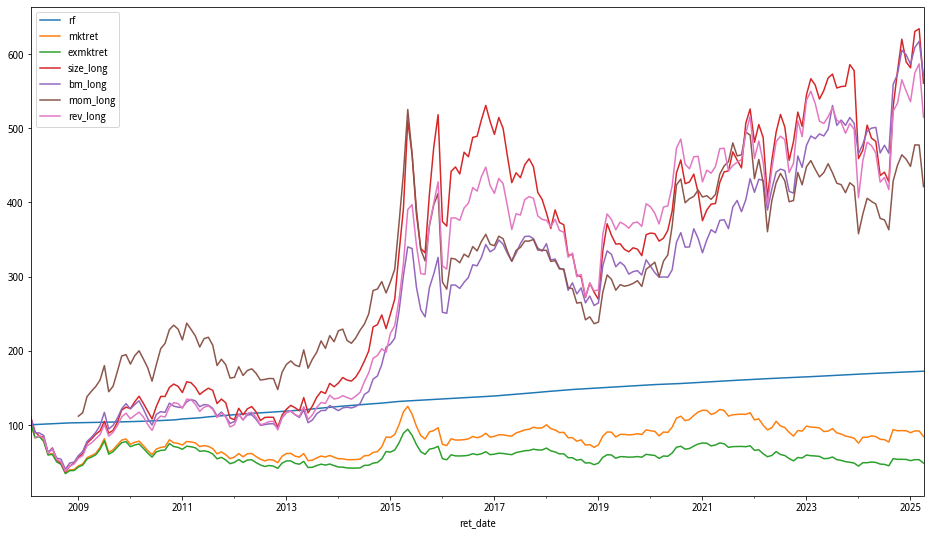

In [60]:
((factors_df+1).cumprod()*100).plot()

In [61]:
factors_df.to_pickle('./output_data/factors/factors_long_only.pkl')

## Long short factors

In [66]:
# factors excluding size
factors_dict = {}
for f in ['bm','mom','rev']:
    if f == 'rev':
        factors_dict[f] = factor(df=ret_df,sort1=f,long_only=False,long_high=False)
    else:
        factors_dict[f] = factor(df=ret_df,sort1=f,long_only=False)

In [67]:
factors_df = pd.DataFrame(factors_dict)

In [68]:
# Size
sort1 = 'bm'
portfolios = double_sort(ret_df,sort1=sort1)
portfolios_vwret = {}
for pf in portfolios.keys():
    temp = portfolios[pf].groupby('ym')['mktcap'].agg({'mktcap_sum':np.sum})
    portfolios[pf] = pd.merge(portfolios[pf], temp, on='ym')
    portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcap_sum']
    portfolios[pf]['weighted_ret'] = portfolios[pf]['ret'] * portfolios[pf]['weight']
    portfolios_vwret[pf] = portfolios[pf].groupby('ret_date')['weighted_ret'].sum()

portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
portfolios_vwret_df.index = portfolios_vwret[f'{sort1}1_size1'].index
portfolios_vwret_df.columns = portfolios_vwret.keys()

factors_df['size'] = (portfolios_vwret_df['bm1_size1'] + portfolios_vwret_df['bm2_size1'] + portfolios_vwret_df['bm3_size1']) / 3 - \
      (portfolios_vwret_df['bm1_size2'] + portfolios_vwret_df['bm2_size2'] + portfolios_vwret_df['bm3_size2']) / 3 

In [69]:
factors_df = pd.merge(index_df, factors_df, on='ret_date')
factors_df.set_index('ret_date',inplace=True)
factors_df = factors_df[['rf','mktret','exmktret','size','bm','mom','rev']]
factors_df

rf    mktret  exmktret      size        bm       mom       rev
ret_date                                                                      
2008-02   0.002946  0.027763  0.024817  0.075388  0.046961       NaN       NaN
2008-03   0.002746 -0.191729 -0.194475  0.014245  0.013079       NaN  0.026409
2008-04   0.002862  0.026264  0.023403 -0.112559  0.025875       NaN  0.082400
2008-05   0.002953 -0.077055 -0.080008  0.063859  0.012648       NaN  0.025727
2008-06   0.003113 -0.232282 -0.235394 -0.029780 -0.036013       NaN -0.018473
2008-07   0.002806  0.018654  0.015848  0.083390  0.032122       NaN  0.057220
2008-08   0.002681 -0.166459 -0.169140 -0.060041  0.022987       NaN  0.004683
2008-09   0.002889 -0.064322 -0.067212 -0.038788  0.072977       NaN  0.029272
...            ...       ...       ...       ...       ...       ...       ...
2024-09   0.001517  0.216653  0.215137  0.037581 -0.036520 -0.115634  0.053000
2024-10   0.001517 -0.016745 -0.018261  0.097708 -0.039297 -0.014374 -0.052111
2024-11   0.001477  0.002654  0.001177  0.068896  0.027723 -0.024740  0.053413
2024-12   0.001401 -0.002120 -0.003521 -0.045635  0.028480  0.049796  0.030094
2025-01   0.001422 -0.028387 -0.029808  0.012440 -0.000507  0.005846 -0.003748
2025-02   0.001557  0.026599  0.025042  0.055009 -0.039080 -0.000528  0.016867
2025-03   0.001607 -0.000615 -0.002222  0.006709  0.028594 -0.003157  0.050567
2025-04   0.001516 -0.082046 -0.083562 -0.031656  0.043471 -0.031166 -0.026050

[207 rows x 7 columns]

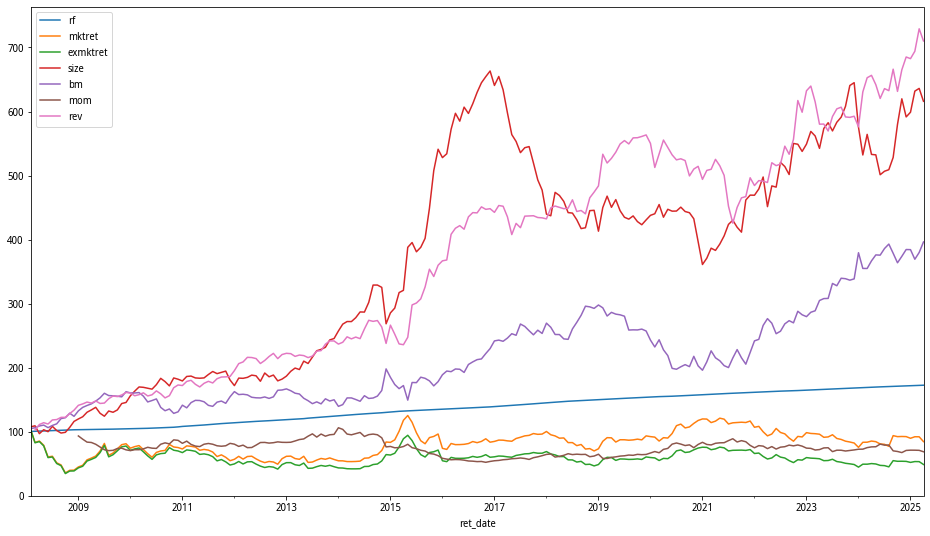

In [70]:
((factors_df+1).cumprod()*100).plot()

In [71]:
factors_df.to_pickle('./output_data/factors/factors.pkl')

# Daily factors

In [72]:
shibor1d = DataAPI.MktIborGet(secID="Shibor1D.IRCN",beginDate=START,endDate=END,field=['tradeDate','rate'],pandas="1")
shibor1d['tradeDate'] = pd.to_datetime(shibor1d['tradeDate'])
shibor1d['rate'] = shibor1d['rate'] * 0.01 / 365
shibor1d.rename(columns={'rate':'rf'},inplace=True)

In [73]:
def daily_factor(df, sort1, sort2='size', long_high=True, long_only=True):
    
    portfolios = double_sort(df=df, sort1=sort1, sort2=sort2)
    portfolios_vwret = {}
    for pf in portfolios.keys():
        temp = portfolios[pf].groupby('ym')['mktcap'].agg({'mktcap_sum':np.sum})
        portfolios[pf] = pd.merge(portfolios[pf], temp, on='ym')
        portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcap_sum']
        df_ = pd.merge(portfolios[pf][['secID','ret_date','weight']],
                       stk_df[['secID','tradeDate','ym','ret_daily']],
                       left_on=['secID','ret_date'],
                       right_on=['secID','ym'])
        df_['weighted_ret_daily'] = df_['ret_daily'] * df_['weight']
        portfolios_vwret[pf] = df_.groupby('tradeDate')['weighted_ret_daily'].sum()

    portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
    portfolios_vwret_df.index = portfolios_vwret[list(portfolios_vwret.keys())[0]].index
    portfolios_vwret_df.columns = portfolios_vwret.keys()
    if long_only:
        if long_high:
            factor = (portfolios_vwret_df[f'{sort1}3_{sort2}1'] + portfolios_vwret_df[f'{sort1}3_{sort2}2']) / 2
        else:
            factor = (portfolios_vwret_df[f'{sort1}1_{sort2}1'] + portfolios_vwret_df[f'{sort1}1_{sort2}2']) / 2
    else:
        if long_high:
            factor = (portfolios_vwret_df[f'{sort1}3_{sort2}1'] + portfolios_vwret_df[f'{sort1}3_{sort2}2']) / 2 - \
                     (portfolios_vwret_df[f'{sort1}1_{sort2}1'] + portfolios_vwret_df[f'{sort1}1_{sort2}2']) / 2
        else:
            factor = (portfolios_vwret_df[f'{sort1}1_{sort2}1'] + portfolios_vwret_df[f'{sort1}1_{sort2}2']) / 2 - \
                     (portfolios_vwret_df[f'{sort1}3_{sort2}1'] + portfolios_vwret_df[f'{sort1}3_{sort2}2']) / 2
    return factor

In [84]:
# Daily factors excluding size
factors_dict = {}
for f in ['bm','mom','rev']:
    if f == 'rev':
        factors_dict[f] = daily_factor(df=ret_df,sort1=f,long_high=False)
    else:
        factors_dict[f] = daily_factor(df=ret_df,sort1=f)

In [85]:
factors_daily = pd.DataFrame(factors_dict)

In [86]:
# The size daily factor
portfolios = double_sort(df=ret_df,sort1='bm')
portfolios_vwret = {}
for pf in portfolios.keys():
    temp = portfolios[pf].groupby('ym')['mktcap'].agg({'mktcap_sum':np.sum})
    portfolios[pf] = pd.merge(portfolios[pf], temp, on='ym')
    portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcap_sum']
    df_ = pd.merge(portfolios[pf][['secID','ret_date','weight']],
                   stk_df[['secID','tradeDate','ym','ret_daily']],
                   left_on=['secID','ret_date'],
                   right_on=['secID','ym'])
    df_['weighted_ret_daily'] = df_['ret_daily'] * df_['weight']
    portfolios_vwret[pf] = df_.groupby('tradeDate')['weighted_ret_daily'].sum()

portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
portfolios_vwret_df.index = portfolios_vwret[list(portfolios_vwret.keys())[0]].index
portfolios_vwret_df.columns = portfolios_vwret.keys()

factors_daily['size'] = (portfolios_vwret_df['bm1_size1'] + portfolios_vwret_df['bm2_size1'] + portfolios_vwret_df['bm3_size1']) / 3

In [87]:
factors_daily

bm       mom       rev      size
tradeDate                                         
2008-02-01 -0.033392       NaN       NaN -0.048805
2008-02-04  0.084448       NaN       NaN  0.081916
2008-02-05  0.003051       NaN       NaN  0.005006
2008-02-13 -0.006506       NaN       NaN -0.000751
2008-02-14  0.019651       NaN       NaN  0.021265
2008-02-15 -0.005241       NaN       NaN -0.002328
2008-02-18  0.025685       NaN       NaN  0.031331
2008-02-19  0.018713       NaN       NaN  0.017340
...              ...       ...       ...       ...
2025-03-26  0.006590  0.007079  0.005925  0.013893
2025-03-27 -0.003529 -0.000978 -0.001411 -0.006631
2025-03-28 -0.011299 -0.011874 -0.010924 -0.016197
2025-03-31 -0.010069 -0.005526 -0.009002 -0.012221
2025-04-01  0.010446  0.000826  0.005083  0.014661
2025-04-02  0.001605  0.004119  0.002258  0.002379
2025-04-03  0.002851 -0.010769 -0.009784 -0.004158
2025-04-07 -0.089972 -0.112886 -0.121024 -0.127854

[4172 rows x 4 columns]

In [88]:
sec_id = ['000906.ZICN']
index_df = DataAPI.MktIdxdGet(indexID=sec_id,beginDate=START,endDate=END,field=['indexID','secShortName','tradeDate','closeIndex','CHGPct'],pandas="1")
index_df['tradeDate'] = pd.to_datetime(index_df['tradeDate'])

index_df = pd.merge(shibor1d,index_df[['tradeDate','CHGPct']],on='tradeDate')
index_df.rename(columns={'CHGPct':'mktret'},inplace=True)
index_df['exmktret'] = index_df['mktret'] - index_df['rf']

In [89]:
index_df

tradeDate        rf    mktret  exmktret
0    2008-01-02  0.000071  0.014058  0.013987
1    2008-01-03  0.000063  0.009669  0.009606
2    2008-01-04  0.000063  0.009535  0.009472
3    2008-01-07  0.000062  0.014649  0.014587
4    2008-01-08  0.000057 -0.009677 -0.009734
5    2008-01-09  0.000052  0.018331  0.018279
6    2008-01-10  0.000052  0.009300  0.009248
7    2008-01-11  0.000052  0.003620  0.003568
...         ...       ...       ...       ...
4186 2025-03-26  0.000049 -0.002362 -0.002411
4187 2025-03-27  0.000048  0.002859  0.002811
4188 2025-03-28  0.000047 -0.005064 -0.005111
4189 2025-03-31  0.000048 -0.007829 -0.007877
4190 2025-04-01  0.000050  0.001633  0.001583
4191 2025-04-02  0.000048 -0.000349 -0.000397
4192 2025-04-03  0.000044 -0.006728 -0.006772
4193 2025-04-07  0.000049 -0.077013 -0.077062

[4194 rows x 4 columns]

In [90]:
factors_daily = pd.merge(index_df[['tradeDate','mktret','rf','exmktret']],factors_daily, on='tradeDate')

factors_daily.set_index('tradeDate',inplace=True)

factors_daily = factors_daily[['rf','mktret','exmktret','size','bm','mom','rev']]

In [91]:
factors_daily.columns = ['rf','mktret','exmktret','size_long','bm_long','mom_long','rev_long']

In [92]:
factors_daily

rf    mktret  exmktret  size_long   bm_long  mom_long  \
tradeDate                                                                 
2008-02-01  0.000055 -0.017938 -0.017993  -0.048805 -0.033392       NaN   
2008-02-04  0.000055  0.082467  0.082412   0.081916  0.084448       NaN   
2008-02-05  0.000062 -0.003663 -0.003725   0.005006  0.003051       NaN   
2008-02-13  0.000061 -0.017980 -0.018041  -0.000751 -0.006506       NaN   
2008-02-14  0.000060  0.014807  0.014747   0.021265  0.019651       NaN   
2008-02-15  0.000060 -0.011791 -0.011851  -0.002328 -0.005241       NaN   
2008-02-18  0.000060  0.022921  0.022861   0.031331  0.025685       NaN   
2008-02-19  0.000060  0.021354  0.021294   0.017340  0.018713       NaN   
...              ...       ...       ...        ...       ...       ...   
2025-03-26  0.000049 -0.002362 -0.002411   0.013893  0.006590  0.007079   
2025-03-27  0.000048  0.002859  0.002811  -0.006631 -0.003529 -0.000978   
2025-03-28  0.000047 -0.005064 -0.005111  -0.016197 -0.011299 -0.011874   
2025-03-31  0.000048 -0.007829 -0.007877  -0.012221 -0.010069 -0.005526   
2025-04-01  0.000050  0.001633  0.001583   0.014661  0.010446  0.000826   
2025-04-02  0.000048 -0.000349 -0.000397   0.002379  0.001605  0.004119   
2025-04-03  0.000044 -0.006728 -0.006772  -0.004158  0.002851 -0.010769   
2025-04-07  0.000049 -0.077013 -0.077062  -0.127854 -0.089972 -0.112886   

            rev_long  
tradeDate             
2008-02-01       NaN  
2008-02-04       NaN  
2008-02-05       NaN  
2008-02-13       NaN  
2008-02-14       NaN  
2008-02-15       NaN  
2008-02-18       NaN  
2008-02-19       NaN  
...              ...  
2025-03-26  0.005925  
2025-03-27 -0.001411  
2025-03-28 -0.010924  
2025-03-31 -0.009002  
2025-04-01  0.005083  
2025-04-02  0.002258  
2025-04-03 -0.009784  
2025-04-07 -0.121024  

[4172 rows x 7 columns]

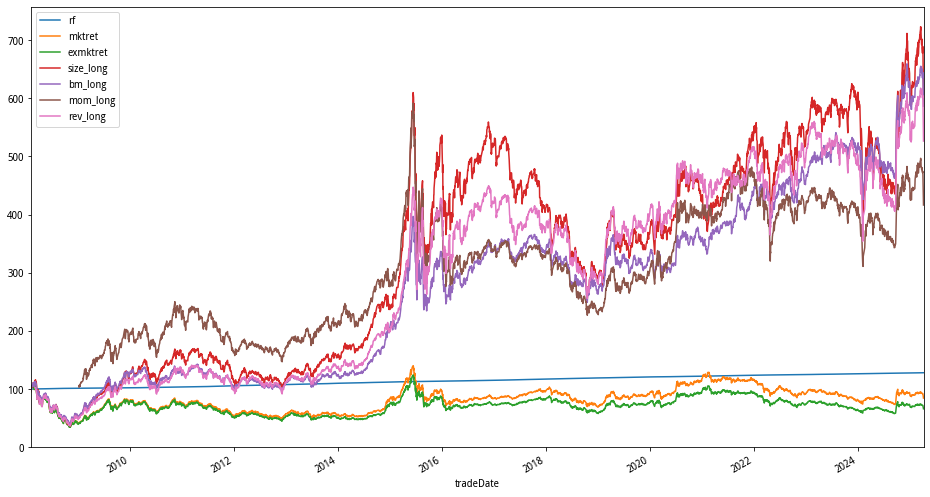

In [93]:
((factors_daily+1).cumprod()*100).plot()

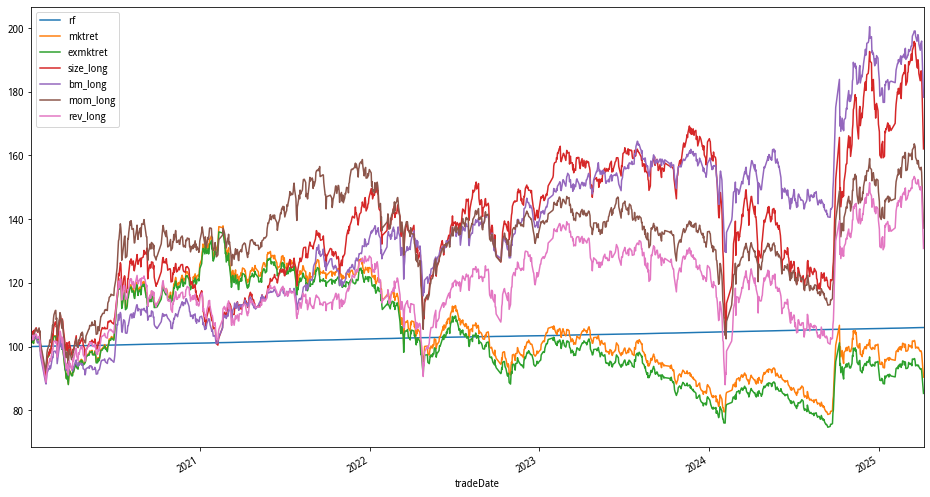

In [94]:
((factors_daily.loc['2020':]+1).cumprod()*100).plot()

In [95]:
factors_daily.to_pickle('./output_data/factors/factors_daily_long_only.pkl')

## Long short factors

In [96]:
# Daily factors excluding size
factors_dict = {}
for f in ['bm','mom','rev']:
    if f == 'rev':
        factors_dict[f] = daily_factor(df=ret_df,sort1=f,long_only=False,long_high=False)
    else:
        factors_dict[f] = daily_factor(df=ret_df,sort1=f,long_only=False)

In [97]:
factors_daily = pd.DataFrame(factors_dict)

In [98]:
# The size daily factor
portfolios = double_sort(df=ret_df,sort1='bm')
portfolios_vwret = {}
for pf in portfolios.keys():
    temp = portfolios[pf].groupby('ym')['mktcap'].agg({'mktcap_sum':np.sum})
    portfolios[pf] = pd.merge(portfolios[pf], temp, on='ym')
    portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcap_sum']
    df_ = pd.merge(portfolios[pf][['secID','ret_date','weight']],
                   stk_df[['secID','tradeDate','ym','ret_daily']],
                   left_on=['secID','ret_date'],
                   right_on=['secID','ym'])
    df_['weighted_ret_daily'] = df_['ret_daily'] * df_['weight']
    portfolios_vwret[pf] = df_.groupby('tradeDate')['weighted_ret_daily'].sum()

portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
portfolios_vwret_df.index = portfolios_vwret[list(portfolios_vwret.keys())[0]].index
portfolios_vwret_df.columns = portfolios_vwret.keys()

factors_daily['size'] = (portfolios_vwret_df['bm1_size1'] + portfolios_vwret_df['bm2_size1'] + portfolios_vwret_df['bm3_size1']) / 3 - \
      (portfolios_vwret_df['bm1_size2'] + portfolios_vwret_df['bm2_size2'] + portfolios_vwret_df['bm3_size2']) / 3 

In [99]:
factors_daily

bm       mom       rev      size
tradeDate                                         
2008-02-01 -0.001618       NaN       NaN -0.030973
2008-02-04  0.006272       NaN       NaN -0.000857
2008-02-05  0.004295       NaN       NaN  0.007516
2008-02-13  0.003438       NaN       NaN  0.016310
2008-02-14  0.004089       NaN       NaN  0.006229
2008-02-15  0.002543       NaN       NaN  0.008785
2008-02-18  0.000150       NaN       NaN  0.009933
2008-02-19 -0.001609       NaN       NaN -0.004680
...              ...       ...       ...       ...
2025-03-26 -0.000558  0.000104 -0.002945  0.013827
2025-03-27 -0.003605  0.002493  0.002178 -0.008142
2025-03-28  0.000280 -0.000645  0.001381 -0.009686
2025-03-31 -0.001523  0.008518 -0.001683 -0.005659
2025-04-01  0.005204 -0.013045 -0.003315  0.012090
2025-04-02  0.001636  0.005175  0.001210  0.001902
2025-04-03  0.013390 -0.010326 -0.003256  0.002388
2025-04-07  0.025557 -0.014863 -0.020701 -0.046436

[4172 rows x 4 columns]

In [100]:
factors_daily = pd.merge(index_df[['tradeDate','rf','mktret','exmktret']],factors_daily, on='tradeDate')

factors_daily.set_index('tradeDate',inplace=True)

factors_daily = factors_daily[['rf','mktret','exmktret','size','bm','mom','rev']]

In [101]:
factors_daily

rf    mktret  exmktret      size        bm       mom  \
tradeDate                                                                
2008-02-01  0.000055 -0.017938 -0.017993 -0.030973 -0.001618       NaN   
2008-02-04  0.000055  0.082467  0.082412 -0.000857  0.006272       NaN   
2008-02-05  0.000062 -0.003663 -0.003725  0.007516  0.004295       NaN   
2008-02-13  0.000061 -0.017980 -0.018041  0.016310  0.003438       NaN   
2008-02-14  0.000060  0.014807  0.014747  0.006229  0.004089       NaN   
2008-02-15  0.000060 -0.011791 -0.011851  0.008785  0.002543       NaN   
2008-02-18  0.000060  0.022921  0.022861  0.009933  0.000150       NaN   
2008-02-19  0.000060  0.021354  0.021294 -0.004680 -0.001609       NaN   
...              ...       ...       ...       ...       ...       ...   
2025-03-26  0.000049 -0.002362 -0.002411  0.013827 -0.000558  0.000104   
2025-03-27  0.000048  0.002859  0.002811 -0.008142 -0.003605  0.002493   
2025-03-28  0.000047 -0.005064 -0.005111 -0.009686  0.000280 -0.000645   
2025-03-31  0.000048 -0.007829 -0.007877 -0.005659 -0.001523  0.008518   
2025-04-01  0.000050  0.001633  0.001583  0.012090  0.005204 -0.013045   
2025-04-02  0.000048 -0.000349 -0.000397  0.001902  0.001636  0.005175   
2025-04-03  0.000044 -0.006728 -0.006772  0.002388  0.013390 -0.010326   
2025-04-07  0.000049 -0.077013 -0.077062 -0.046436  0.025557 -0.014863   

                 rev  
tradeDate             
2008-02-01       NaN  
2008-02-04       NaN  
2008-02-05       NaN  
2008-02-13       NaN  
2008-02-14       NaN  
2008-02-15       NaN  
2008-02-18       NaN  
2008-02-19       NaN  
...              ...  
2025-03-26 -0.002945  
2025-03-27  0.002178  
2025-03-28  0.001381  
2025-03-31 -0.001683  
2025-04-01 -0.003315  
2025-04-02  0.001210  
2025-04-03 -0.003256  
2025-04-07 -0.020701  

[4172 rows x 7 columns]

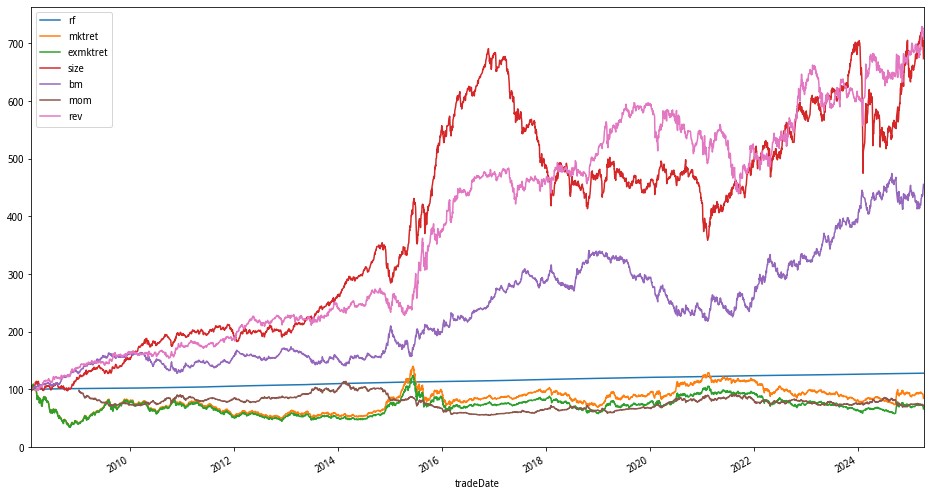

In [102]:
((factors_daily+1).cumprod()*100).plot()

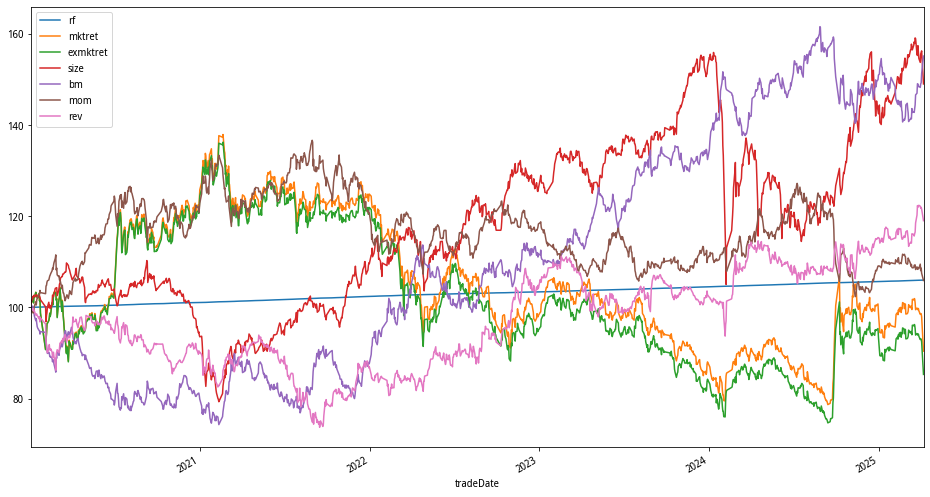

In [103]:
((factors_daily.loc['2020':]+1).cumprod()*100).plot()

In [104]:
factors_daily.to_pickle('./output_data/factors/factors_daily.pkl')